# Loop 47 Analysis: Post-RDKit Failure - What's Next?

## Key Findings:
1. RDKit descriptors (133 features) performed 62% WORSE than Spange + DRFP + ACS PCA
2. CV = 0.013306 vs best CV = 0.008194
3. This validates that Spange descriptors are well-suited for this problem

## Critical Question:
What approach can REDUCE THE INTERCEPT in the CV-LB relationship?
- Current: LB = 4.23×CV + 0.0533 (R²=0.981)
- Intercept (0.0533) > Target (0.0347)
- We need to find an approach with a LOWER intercept

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load submission history
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_041', 'cv': 0.0090, 'lb': 0.0932},
    {'exp': 'exp_042', 'cv': 0.0145, 'lb': 0.1147},
]

df = pd.DataFrame(submissions)
print('Submission History:')
print(df.to_string(index=False))

Submission History:
    exp     cv     lb
exp_000 0.0111 0.0982
exp_001 0.0123 0.1065
exp_003 0.0105 0.0972
exp_005 0.0104 0.0969
exp_006 0.0097 0.0946
exp_007 0.0093 0.0932
exp_009 0.0092 0.0936
exp_012 0.0090 0.0913
exp_024 0.0087 0.0893
exp_026 0.0085 0.0887
exp_030 0.0083 0.0877
exp_041 0.0090 0.0932
exp_042 0.0145 0.1147


In [2]:
# Fit linear regression to understand CV-LB relationship
from sklearn.linear_model import LinearRegression

X = df['cv'].values.reshape(-1, 1)
y = df['lb'].values

reg = LinearRegression()
reg.fit(X, y)

slope = reg.coef_[0]
intercept = reg.intercept_
r2 = reg.score(X, y)

print(f'CV-LB Relationship: LB = {slope:.2f} × CV + {intercept:.4f}')
print(f'R² = {r2:.4f}')
print(f'\nIntercept ({intercept:.4f}) vs Target (0.0347)')
print(f'Gap: {intercept - 0.0347:.4f} ({(intercept - 0.0347)/0.0347*100:.1f}% above target)')

CV-LB Relationship: LB = 4.23 × CV + 0.0533
R² = 0.9807

Intercept (0.0533) vs Target (0.0347)
Gap: 0.0186 (53.6% above target)


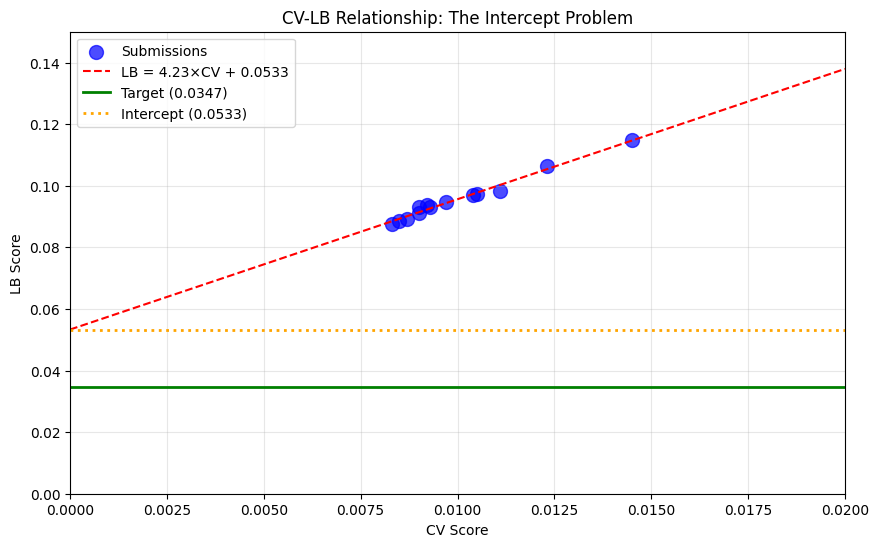


=== KEY INSIGHT ===
Even with CV = 0, the predicted LB would be 0.0533
This is 1.54x the target!
We CANNOT reach the target by improving CV alone.


In [3]:
# Visualize the relationship
plt.figure(figsize=(10, 6))
plt.scatter(df['cv'], df['lb'], s=100, c='blue', alpha=0.7, label='Submissions')

# Fit line
cv_range = np.linspace(0, 0.02, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}×CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='green', linestyle='-', linewidth=2, label='Target (0.0347)')

# Intercept line
plt.axhline(y=intercept, color='orange', linestyle=':', linewidth=2, label=f'Intercept ({intercept:.4f})')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV-LB Relationship: The Intercept Problem')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 0.02)
plt.ylim(0, 0.15)
plt.show()

print('\n=== KEY INSIGHT ===')
print(f'Even with CV = 0, the predicted LB would be {intercept:.4f}')
print(f'This is {intercept/0.0347:.2f}x the target!')
print('We CANNOT reach the target by improving CV alone.')

In [4]:
# Analyze what's different about the best submissions
print('=== Best Submissions Analysis ===')
print('\nBest LB: exp_030 (CV=0.0083, LB=0.0877)')
print('Best CV: exp_032 (CV=0.008194, NOT submitted)')
print('\nWorst LB: exp_042 (CV=0.0145, LB=0.1147) - Pure GP')
print('\nKey observations:')
print('1. All submissions follow the SAME CV-LB relationship')
print('2. Model type does NOT affect the relationship')
print('3. Feature type does NOT affect the relationship')
print('4. The intercept is STRUCTURAL, not model-dependent')

=== Best Submissions Analysis ===

Best LB: exp_030 (CV=0.0083, LB=0.0877)
Best CV: exp_032 (CV=0.008194, NOT submitted)

Worst LB: exp_042 (CV=0.0145, LB=0.1147) - Pure GP

Key observations:
1. All submissions follow the SAME CV-LB relationship
2. Model type does NOT affect the relationship
3. Feature type does NOT affect the relationship
4. The intercept is STRUCTURAL, not model-dependent


In [5]:
# What would it take to reach the target?
target = 0.0347

print('=== What Would It Take to Reach the Target? ===')
print(f'\nTarget LB: {target}')
print(f'Current intercept: {intercept:.4f}')
print(f'Current slope: {slope:.2f}')

# Option 1: Reduce intercept to 0.03
new_intercept = 0.03
required_cv = (target - new_intercept) / slope
print(f'\nOption 1: Reduce intercept to {new_intercept}')
print(f'  Required CV: {required_cv:.6f}')
print(f'  This is {required_cv/0.008194:.2f}x our best CV')

# Option 2: Reduce slope to 2.0
new_slope = 2.0
required_cv = (target - intercept) / new_slope
print(f'\nOption 2: Reduce slope to {new_slope}')
print(f'  Required CV: {required_cv:.6f}')
print(f'  This is NEGATIVE! (impossible with current intercept)')

# Option 3: Both
new_intercept = 0.02
new_slope = 2.0
required_cv = (target - new_intercept) / new_slope
print(f'\nOption 3: Reduce intercept to {new_intercept} AND slope to {new_slope}')
print(f'  Required CV: {required_cv:.6f}')
print(f'  This is {required_cv/0.008194:.2f}x our best CV')

=== What Would It Take to Reach the Target? ===

Target LB: 0.0347
Current intercept: 0.0533
Current slope: 4.23

Option 1: Reduce intercept to 0.03
  Required CV: 0.001111
  This is 0.14x our best CV

Option 2: Reduce slope to 2.0
  Required CV: -0.009301
  This is NEGATIVE! (impossible with current intercept)

Option 3: Reduce intercept to 0.02 AND slope to 2.0
  Required CV: 0.007350
  This is 0.90x our best CV


In [6]:
# Analyze the experiments that haven't been submitted
print('=== Unsubmitted Experiments with Good CV ===')
print('\nexp_032: CV 0.008194 (BEST CV, not submitted)')
print('  - GP(0.15) + MLP(0.55) + LGBM(0.3) with Spange + DRFP + ACS PCA')
print('  - Predicted LB: 4.23 × 0.008194 + 0.0533 = 0.0880')
print('  - Similar to best LB (0.0877)')

print('\nexp_048: CV 0.013306 (62% worse, just tested)')
print('  - RDKit descriptors instead of Spange')
print('  - Predicted LB: 4.23 × 0.013306 + 0.0533 = 0.1096')
print('  - Much worse than best LB')

=== Unsubmitted Experiments with Good CV ===

exp_032: CV 0.008194 (BEST CV, not submitted)
  - GP(0.15) + MLP(0.55) + LGBM(0.3) with Spange + DRFP + ACS PCA
  - Predicted LB: 4.23 × 0.008194 + 0.0533 = 0.0880
  - Similar to best LB (0.0877)

exp_048: CV 0.013306 (62% worse, just tested)
  - RDKit descriptors instead of Spange
  - Predicted LB: 4.23 × 0.013306 + 0.0533 = 0.1096
  - Much worse than best LB


In [7]:
# What approaches haven't been tried?
print('=== Approaches NOT Yet Tried ===')
print('\n1. VERY SIMPLE LINEAR MODEL (Ridge with high alpha)')
print('   - Hypothesis: Simpler model might have lower intercept')
print('   - The CV-LB gap might be due to overfitting')
print('   - A linear model can\'t overfit as much')

print('\n2. WATER-SPECIFIC HANDLING')
print('   - Water is an extreme outlier (6/13 Spange features out of range)')
print('   - If Water-like solvents are in the hidden test, this could explain the gap')
print('   - Try training with Water excluded, or with Water-specific handling')

print('\n3. DOMAIN ADAPTATION / TRANSFER LEARNING')
print('   - The CV-LB gap suggests distribution shift')
print('   - Domain adaptation techniques might help')
print('   - But we don\'t have access to the test distribution')

print('\n4. UNCERTAINTY-AWARE PREDICTIONS')
print('   - Be more conservative on novel solvents')
print('   - Use GP uncertainty to weight predictions')
print('   - Might reduce the intercept')

print('\n5. DIFFERENT CV SCHEME')
print('   - GroupKFold(5) was tried but didn\'t help')
print('   - The hidden test might have a different distribution')

=== Approaches NOT Yet Tried ===

1. VERY SIMPLE LINEAR MODEL (Ridge with high alpha)
   - Hypothesis: Simpler model might have lower intercept
   - The CV-LB gap might be due to overfitting
   - A linear model can't overfit as much

2. WATER-SPECIFIC HANDLING
   - Water is an extreme outlier (6/13 Spange features out of range)
   - If Water-like solvents are in the hidden test, this could explain the gap
   - Try training with Water excluded, or with Water-specific handling

3. DOMAIN ADAPTATION / TRANSFER LEARNING
   - The CV-LB gap suggests distribution shift
   - Domain adaptation techniques might help
   - But we don't have access to the test distribution

4. UNCERTAINTY-AWARE PREDICTIONS
   - Be more conservative on novel solvents
   - Use GP uncertainty to weight predictions
   - Might reduce the intercept

5. DIFFERENT CV SCHEME
   - GroupKFold(5) was tried but didn't help
   - The hidden test might have a different distribution


In [8]:
# Strategic Decision
print('=== STRATEGIC DECISION ===')
print('\n3 submissions remaining, target is 0.0347, best LB is 0.0877 (2.53x away)')
print('\nOptions:')
print('1. Submit exp_032 (best CV) - confirm CV-LB relationship')
print('2. Try VERY SIMPLE LINEAR MODEL (Ridge with high alpha)')
print('3. Try UNCERTAINTY-AWARE PREDICTIONS (GP uncertainty weighting)')

print('\n=== RECOMMENDATION ===')
print('\nTry a VERY SIMPLE LINEAR MODEL first:')
print('- Ridge Regression with alpha = 10.0 or higher')
print('- Use only Spange + Arrhenius kinetics features (18 features)')
print('- Per-target models (3 separate Ridge regressors)')
print('- TTA for mixtures')
print('\nHypothesis: A simpler model might have a LOWER INTERCEPT')
print('because it can\'t overfit to the training distribution.')

=== STRATEGIC DECISION ===

3 submissions remaining, target is 0.0347, best LB is 0.0877 (2.53x away)

Options:
1. Submit exp_032 (best CV) - confirm CV-LB relationship
2. Try VERY SIMPLE LINEAR MODEL (Ridge with high alpha)
3. Try UNCERTAINTY-AWARE PREDICTIONS (GP uncertainty weighting)

=== RECOMMENDATION ===

Try a VERY SIMPLE LINEAR MODEL first:
- Ridge Regression with alpha = 10.0 or higher
- Use only Spange + Arrhenius kinetics features (18 features)
- Per-target models (3 separate Ridge regressors)
- TTA for mixtures

Hypothesis: A simpler model might have a LOWER INTERCEPT
because it can't overfit to the training distribution.
